<a href="https://colab.research.google.com/github/Stone-bridge-NLP/BERT/blob/main/GenreClassification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting environment

In [ ]:
# required packages to use BERT via hub models
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# additional packages required (to avoid error, not mentioned in the tutorial)
!pip install huggingface_hub
!pip install tokenizers

     |████████████████████████████████| 59 kB 2.7 MB/s 
     |████████████████████████████████| 3.3 MB 4.1 MB/s 


In [ ]:
# clone my github repo to import utils.py
!git clone https://github.com/Stone-bridge-NLP/BERT.git
%cd /content/BERT

Cloning into 'BERT'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 37 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (37/37), done.
/content/BERT


In [ ]:
# download shared dataset to local disk
# [차도인] [오후 9:37] https://drive.google.com/file/d/168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-/view?usp=sharing
!gdown --id 168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
FILENAME = 'preprocessed_train_data.csv'

Downloading...
From: https://drive.google.com/uc?id=168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
To: /content/BERT/preprocessed_train_data.csv
100% 252M/252M [00:02<00:00, 95.4MB/s]


# Train model

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import utils

In [ ]:
train_dataset = pd.read_csv('./'+FILENAME)
print(train_dataset)

        Unnamed: 0  Genre                                             Lyrics
0                0   Rock  it starts with pain followed by hate fueled by...
1                1   Rock  freedom alone again again alone patiently wait...
2                2   Rock  biting the hand that feeds you lying to the vo...
3                3   Rock  you say you know just who i am but you can t i...
4                4   Rock  my heart is beating faster can t control these...
...            ...    ...                                                ...
209268      249943    R&B  i m the best friend he s got i d give him the ...
209269      249944    Pop  bad boys blue i totally miss you i did you wro...
209270      249945    Pop  forgive me for the things that i never said to...
209271      249946  Indie  the day they found a cure for aids the day the...
209272      249947    Pop  fourth of july has come it s custom that we go...

[209273 rows x 3 columns]


In [ ]:
# Balance sampling of the DATA.
# problem here is that some genre is oversampled too much(copied 11 times)
# another problem is that this samping happens during the runtime,
# so train set and validation set is mixed up every new runtime
# ==========SOLUTION========
# First split the whole train data into 8:2 train and validation set
# to make sure they do not get mixed up
# Reduce the dataset to desired size afterwards
# 
# To prevent overcopying, start the learning with equally distributed small dataset
# Rather than overcopying, use the weighted loss
# while gradually breaking the balance by less undersampling

Genre = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
# remove every column except 'Genre' and 'Lyrics'
train_dataset = train_dataset[['Genre', 'Lyrics']]
# remove slight error in the dataset
train_dataset = train_dataset.drop(train_dataset[train_dataset['Genre']=='en'].index)

# manually sample same fraction from each Genre to prevent the problem of
# validation set not representing the dataset
# more about this from here:
# https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/#:~:text=the%20Validation%20Dataset-,Unrepresentative%20Validation%20Dataset,-An%20unrepresentative%20validation

print('====== validation set =======')
val_d = []
for genre in Genre:
  td = train_dataset[train_dataset['Genre'] == genre]
  val_d.append(td.sample(frac=0.2,random_state=31415))
  print(f'{genre}\tsample ratio\t {len(td)}:{len(val_d[-1])}')  
val_dataset = pd.concat(val_d)

# split train and validation set
train_dataset = train_dataset.drop(val_dataset.index)
train_dataset = train_dataset.reset_index().drop(columns='index')
val_dataset = val_dataset.reset_index().drop(columns='index')
    

====== validation set =======
Electronic	sample ratio	 1831:366
Country	sample ratio	 1594:319
R&B	sample ratio	 2482:496
Jazz	sample ratio	 7026:1405
Indie	sample ratio	 6509:1302
Pop	sample ratio	 69934:13987
Folk	sample ratio	 7333:1467
Metal	sample ratio	 17283:3457
Hip-Hop	sample ratio	 2068:414
Rock	sample ratio	 93213:18643


In [ ]:
# Custom class from torch.utils.data.Dataset
# Tokenization and integer labeling happens here
# shuffle and batch tokenizing can be done with torch.utils.data.DataLoader
class LyricsAndGenreDataset(Dataset):
  def __init__(self, dataframe, tokenizer, num_sentence):
    self.df = dataframe
    self.tk = tokenizer
    self.num_sentence = num_sentence
    self.genre_name2id = {
        'Electronic':0, 
        'Country':1, 
        'R&B':2, 
        'Jazz':3, 
        'Indie':4, 
        'Pop':5, 
        'Folk':6, 
        'Metal':7, 
        'Hip-Hop':8, 
        'Rock':9}

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    genre = self.genre_name2id[self.df['Genre'][idx]]
    lyric = [self.df['Lyrics'][idx]]

    with torch.no_grad():
      indexed_tokens = self.tk.batch_encode_plus(
            lyric, add_special_tokens=True, padding= 'max_length', 
            max_length=2**9*self.num_sentence, truncation=True)
      
      tk_tensor = torch.tensor(indexed_tokens['input_ids']).view(-1,2**9)
      sg_tensor = torch.tensor(indexed_tokens['token_type_ids']).view(-1,2**9)
      at_tensor = torch.tensor(indexed_tokens['attention_mask']).view(-1,2**9)

    return genre, tk_tensor, sg_tensor, at_tensor



In [ ]:
# classifier model
# manually stacked lstm layer to gradually decrease hidden_size
# one FC layer attached at the end
# ====================================
# Param seq_len has the sequence length info of each song in a batch.
# For some songs, sequence ends way earlier than 512 tokens, resulting 
# long sequence of padding at the end. This might make it hard for lstm
# to extract useful information from the sequence. With the info from seq_len
# it pulls output from certain time step and feeds to the FC layer.
class TextLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, n_class):
    super(TextLSTM, self).__init__()

    self.hidden_size = hidden_size

    self.lstm1 = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size*5,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm2 = nn.LSTM(
              input_size=hidden_size*5,
              hidden_size=hidden_size*4,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.lstm3 = nn.LSTM(
              input_size=hidden_size*4,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm4 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.dense = nn.Sequential(
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))

  def forward(self, X, seq_len):
    # X of shape N,L,Hin
    # hidden_and_cell zeros by default
    # outputs of shape N,L,Hout
    outputs = X
    outputs, hidden_and_cell = self.lstm1(outputs)
    outputs, hidden_and_cell = self.lstm2(outputs)
    outputs, hidden_and_cell = self.lstm3(outputs)
    outputs, hidden_and_cell = self.lstm4(outputs)
    seq_len = torch.tile(seq_len.view(batch_size,1,1),(1,1,self.hidden_size))
    outputs = torch.gather(outputs,1,seq_len)
    outputs = outputs[:,-1]  # last hidden Layer of shape N,Hout
    return self.dense(outputs) # return of shape N,n_class

In [ ]:
#### hyperparameters ####
# =======================
# Training whole dataset took way too much time to train, so used
# only small fraction(param dataset_fraction) of the dataset.
# To make it even faster, each time the graph showed overfitting, I gradually
# increased dataset, starting from fraction of 0.05
#
# Chose the biggest batch size possible to make training faster.

epoch = 35
lr = 0.001
batch_size = 128
num_sentences = 1 # one sentence has 512 tokens
hidden_size = 128
save_epoch = 1
save_path = 'checkpoint.pth'
epoch_start = 0
dataset_fraction = 0.3

# fixed
v_dim = 768
n_genre = 10
genre_id2name = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
genre_name2id = {'Electronic':0, 'Country':1, 'R&B':2, 'Jazz':3, 'Indie':4, 'Pop':5, 'Folk':6, 'Metal':7, 'Hip-Hop':8, 'Rock':9}
device = torch.device('cuda') if (torch.cuda.is_available())else torch.device('cpu')

In [ ]:
# load pretrained BERT tokenizer and bare BERT model
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')
bert_embedding = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased').to(device)

# undersample the dataset to desired size
reduced_train_dset,tr_loss_coef = utils.dfRandomSample(train_dataset,dataset_fraction)
print(tr_loss_coef)
reduced_val_dset, vl_loss_coef = utils.dfRandomSample(val_dataset,dataset_fraction)
print(vl_loss_coef)

# declare torch.utils.data.Dataset
train_set = LyricsAndGenreDataset(reduced_train_dset,tokenizer,num_sentences)
val_set = LyricsAndGenreDataset(reduced_val_dset,tokenizer,num_sentences)

# train and validation data loader
train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)
val_loader = DataLoader(val_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)

lstm_classifier = TextLSTM(v_dim, hidden_size, n_genre).to(device)

# load model if possible
try:
  cp = torch.load(save_path)
  epoch_start= cp['current_epoch']+1
  lstm_classifier.load_state_dict(cp['model'])
  print(f'\nsavefile from {save_path} loaded')
except FileNotFoundError:
  print('\nno savefile to load')
# summary of the classifier
print(lstm_classifier)
print(sum(p.numel() for p in lstm_classifier.parameters() if p.requires_grad))
# Cross entropy loss. reduction=none to apply weighted loss
loss_func = nn.CrossEntropyLoss(reduction='none')
# only optimize classifier, not the BERT model
params = list(lstm_classifier.parameters())
optimizer = optim.Adam(params, lr=lr)

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /root/.cache/torch/hub/master.zip


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Country	 sample ratio	 1275:1275
Electronic	 sample ratio	 1465:1465
Hip-Hop	 sample ratio	 1654:1654
R&B	 sample ratio	 1986:1986
Indie	 sample ratio	 5207:5207
Jazz	 sample ratio	 5621:5621
Folk	 sample ratio	 5866:5866
Metal	 sample ratio	 13826:9050
Pop	 sample ratio	 55947:9050
Rock	 sample ratio	 74570:9051
Total size : 50225

{'Rock': 0.5549110595514308, 'Pop': 0.5549723756906078, 'Metal': 0.5549723756906078, 'Folk': 0.8562052505966586, 'Jazz': 0.8935242839352429, 'Indie': 0.9645669291338582, 'R&B': 2.5289526686807653, 'Hip-Hop': 3.036577992744861, 'Electronic': 3.4283276450511946, 'Country': 3.9392156862745096}
Country	 sample ratio	 319:319
Electronic	 sample ratio	 366:366
Hip-Hop	 sample ratio	 414:414
R&B	 sample ratio	 496:496
Indie	 sample ratio	 1302:1302
Jazz	 sample ratio	 1405:1405
Folk	 sample ratio	 1467:1467
Metal	 sample ratio	 3457:2262
Pop	 sample ratio	 13987:2262
Rock	 sample ratio	 18643:2263
Total size : 12556

{'Rock': 0.5548387096774193, 'Pop': 0.555083996

In [ ]:
# lists to plot
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
# set the classifier to train mode
lstm_classifier.train()

for e in range(epoch_start, epoch, 1):
  # train
  for b,batch in enumerate(train_loader):
    label_batch = batch[0].to(device) # label batch
    tk_batch = batch[1].to(device) # tokens
    sg_batch = batch[2].to(device) # segments. zeros in this case
    at_batch = batch[3].to(device) # attention_mask

    # calculate sequence length from attention mask
    seq_len = np.sum(at_batch.detach().cpu().numpy(), axis=(1,2)) - 1
    seq_len = torch.LongTensor(seq_len).to(device)

    # bring coefficent for weighted loss for each song in batch
    loss_coef = torch.tensor(
        [tr_loss_coef[genre_id2name[i]] for i in batch[0]]).to(device)

    # don't need grad in bert embedding
    with torch.no_grad():
      embedding = bert_embedding(
          tk_batch.view(-1,2**9), 
          token_type_ids= sg_batch.view(-1,2**9),
          attention_mask=at_batch.view(-1,2**9))

    # embedded tokens of shape (batch_size, 2**9*num_sentences, 768)
    embedded_tokens = embedding[0].detach().view(batch_size,2**9*num_sentences,-1)

    # classifier feed forward
    output = lstm_classifier.forward(embedded_tokens, seq_len)
    # optimizer step. apply weighted loss here
    optimizer.zero_grad()
    loss = torch.mean(loss_coef*loss_func(output, label_batch))
    loss.backward()
    optimizer.step()
    
    # save data for graph plotting
    if b%4 == 0:
      train_loss_list.append(float(loss.detach().cpu().data))
      pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
      acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
      train_acc_list.append(float(acc))

      print(f'\rTRAIN: epoch [{e}/{epoch}] batch [{b}/{len(train_loader)}]\
       loss {train_loss_list[-1]}\t acc {train_acc_list[-1]}', end='\t')

  # validation
  for b,batch in enumerate(val_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)
    at_batch = batch[3].to(device)

    seq_len = np.sum(at_batch.detach().cpu().numpy(), axis=(1,2)) - 1
    seq_len = torch.LongTensor(seq_len).to(device)

    loss_coef = torch.tensor(
        [vl_loss_coef[genre_id2name[i]] for i in batch[0]]).to(device)

    with torch.no_grad():
      embedding = bert_embedding(
          tk_batch.view(-1,2**9), 
          token_type_ids= sg_batch.view(-1,2**9),
          attention_mask=at_batch.view(-1,2**9))

      embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

      output = lstm_classifier.forward(embedded_tokens, seq_len)

      optimizer.zero_grad()
      loss = torch.mean(loss_coef*loss_func(output, label_batch))
    

    val_loss_list.append(float(loss.detach().cpu().data))
    pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
    acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
    val_acc_list.append(float(acc))

    print(f'\rVAL: [{e}/{epoch}] batch [{b}/{len(val_loader)}]\
       loss {val_loss_list[-1]}\t acc {val_acc_list[-1]}', end='\t')

  if e%save_epoch == 0:
    utils.save_checkpoint(e,lstm_classifier,save_path)

VAL: [34/35] batch [97/98]       loss 1.9328067549245735	 acc 0.34375	

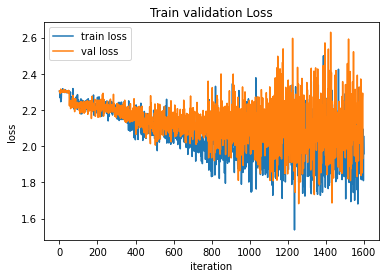

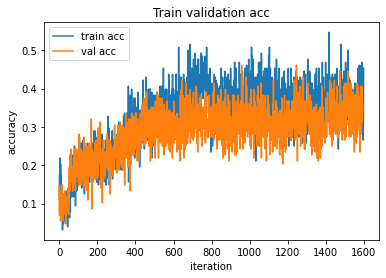

In [ ]:
import matplotlib.pyplot as plt

try:
  tll = np.load('train_loss_list.npy')
  vll = np.load('val_loss_list.npy')
  tal = np.load('train_acc_list.npy')
  val = np.load('val_acc_list.npy')

  tll = tll.tolist() + train_loss_list
  vll = vll.tolist() + val_loss_list
  tal = tal.tolist() + train_acc_list
  val = val.tolist() + val_acc_list
except FileNotFoundError:
  print('no savefile')
  tll = train_loss_list
  vll = val_loss_list
  tal = train_acc_list
  val = val_acc_list



plt.title('Train validation Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(tll, label='train loss')
plt.plot(vll, label='val loss')
plt.legend()
plt.show()


plt.title('Train validation acc')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.plot(tal, label='train acc')
plt.plot(val, label='val acc')
plt.legend()
plt.show()

In [ ]:
np.save('train_loss_list.npy',tll)
np.save('val_loss_list.npy',vll)
np.save('train_acc_list.npy',tal)
np.save('val_acc_list.npy',val)

In [ ]:
# copy the test data from shared drive 
# [차도인] [오후 9:37] https://drive.google.com/file/d/168qGvi5w4Wwgu5QTpPoLkZzoJNAgyc6b/view?usp=sharing
!gdown --id 168qGvi5w4Wwgu5QTpPoLkZzoJNAgyc6b
TESTFILENAME = 'preprocessed_test_data.csv'

Downloading...
From: https://drive.google.com/uc?id=168qGvi5w4Wwgu5QTpPoLkZzoJNAgyc6b
To: /content/BERT/preprocessed_test_data.csv
100% 9.63M/9.63M [00:00<00:00, 36.5MB/s]


In [ ]:
# load and check the test dataset
batch_size = 128

test_dataset = pd.read_csv('./'+TESTFILENAME)
print(test_dataset['Genre'].value_counts())
print(len(test_dataset))

# declare torch.utils.data.Dataset
test_set = LyricsAndGenreDataset(test_dataset,tokenizer,num_sentences)

# test data loader
test_loader = DataLoader(test_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)



Rock          1410
Pop           1110
Hip-Hop        960
Country        810
Metal          810
Electronic     659
Jazz           659
Indie          510
R&B            509
Folk           495
Name: Genre, dtype: int64
7932


In [ ]:
# test the model with test dataset
lstm_classifier.eval()
c_mat = np.zeros((10,4)) # confusion matrix. TP, FP, FN, TN
f1 = []
with torch.no_grad():
  for b, batch in enumerate(test_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)
    at_batch = batch[3].to(device)

    seq_len = np.sum(at_batch.detach().cpu().numpy(), axis=(1,2)) - 1
    seq_len = torch.LongTensor(seq_len).to(device)

    embedding = bert_embedding(
        tk_batch.view(-1,2**9), 
        token_type_ids= sg_batch.view(-1,2**9),
        attention_mask=at_batch.view(-1,2**9))

    embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

    output = lstm_classifier.forward(embedded_tokens, seq_len)
    
    pred = torch.argmax(output,axis=1)

    acc = float(torch.sum(pred == label_batch))/batch_size
    print(f'\rbatch [{b}/{len(test_loader)}] acc: {acc}', end='\t')

    # build confusion matrix
    for i in range(10):
      c_mat[i,0] += int(torch.sum((pred == i)*(label_batch == i)))
      c_mat[i,1] += int(torch.sum((pred == i)*(label_batch != i)))
      c_mat[i,2] += int(torch.sum((pred != i)*(label_batch == i)))
      c_mat[i,3] += int(torch.sum((pred != i)*(label_batch != i)))


# calculate precision, recall and f1-score
precision = [c[0]/(c[0]+c[1]) if c[0] != 0 else 0 for c in c_mat]
recall = [c[0]/(c[0]+c[2]) if c[0] != 0 else 0 for c in c_mat]
f1 = [2*p*r/(p+r) if p*r != 0 else 0 for p, r in zip(precision,recall)]


In [ ]:
# show confusion matrix
print('confusion matrix. TP, FP, FN, TN')
for g, c in zip(genre_id2name,c_mat):
  print('%-15s'%(g), c)

confusion matrix. TP, FP, FN, TN
Electronic      [ 116.  495.  534. 6663.]
Country         [ 188.  253.  605. 6762.]
R&B             [  67.  270.  430. 7041.]
Jazz            [ 208.  370.  447. 6783.]
Indie           [ 228. 1476.  274. 5830.]
Pop             [ 239.  487.  851. 6231.]
Folk            [ 198.  725.  291. 6594.]
Metal           [ 628.  771.  168. 6241.]
Hip-Hop         [ 756.  215.  189. 6648.]
Rock            [  22.   96. 1369. 6321.]


In [ ]:
# compare f1 score with random prediction
test_dataset = pd.read_csv('./'+TESTFILENAME)

P = [n/len(test_dataset) for n in test_dataset['Genre'].value_counts()]
f1_score = {n:2*p*0.5/(0.5+p) for n, p in zip(test_dataset['Genre'].value_counts().index, P)}
print('%-15s %11s   %11s'%('Genre', 'f1 test', 'f1 at least'))
for i, g in enumerate(genre_id2name):
  print('%-15s %-2.9f   %-2.9f'%(g, f1[i], f1_score[g]))

print('-'*43)
print('%-15s %-2.9f   %-2.9f'%('average',np.mean(f1),sum(f1_score.values())/10))

# print(test_dataset['Genre'].value_counts())

Genre               f1 test   f1 at least
Electronic      0.183980967   0.142486486
Country         0.304700162   0.169597990
R&B             0.160671463   0.113743017
Jazz            0.337388483   0.142486486
Indie           0.206708976   0.113941019
Pop             0.263215859   0.218676123
Folk            0.280453258   0.110961668
Metal           0.572209567   0.169597990
Hip-Hop         0.789144050   0.194884287
Rock            0.029158383   0.262276786
-------------------------------------------
average         0.312763117   0.163865185
